In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from csd_simulations import (
    simulate_no_csd,
    simulate_no_csd_same_z,
    simulate_no_csd_large_z,
)
from models import (
    train_ridge,
    train_rf,
    train_mlp,
    get_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 3
n_per_domain = 25
p = 10
k = 5
noise_scale = 1

simulate_same_z = True

In [3]:
if k is not None:
    xs, ys = simulate_no_csd_large_z(n_domains, n_per_domain, p, k, noise_scale)
elif simulate_same_z:
    xs, ys = simulate_no_csd_same_z(n_domains, n_per_domain, p, noise_scale)
else:
    xs, ys = simulate_no_csd(n_domains, n_per_domain, p, noise_scale)

print(xs.shape)
print(xs[:5, :5])

(75, 10)
[[ 7.16372732e-01  1.93104653e-03  6.57310362e-01  1.46807004e+00
   1.86566522e+00]
 [-1.01258509e-01 -2.26640312e+00 -4.62214808e-01  3.67276344e-01
   2.11868324e-01]
 [-1.09641684e+00 -1.65428383e+00 -7.40010512e-01 -1.90531563e+00
   3.36522418e+00]
 [-1.24360953e+00 -1.44671719e+00 -3.79840099e-01 -1.44138196e+00
  -4.00928608e-01]
 [-1.64138627e+00  1.12200153e+00  2.20793849e+00  2.56039971e+00
  -2.36147198e+00]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(75, 1)
[[ 1]
 [-1]
 [-1]]


In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,1.929740,-4.401387,0,1
1,0.154118,-7.289355,0,-1
2,1.089033,-8.300082,0,-1
3,1.693398,-8.065521,0,-1
4,2.892569,-5.502921,0,1


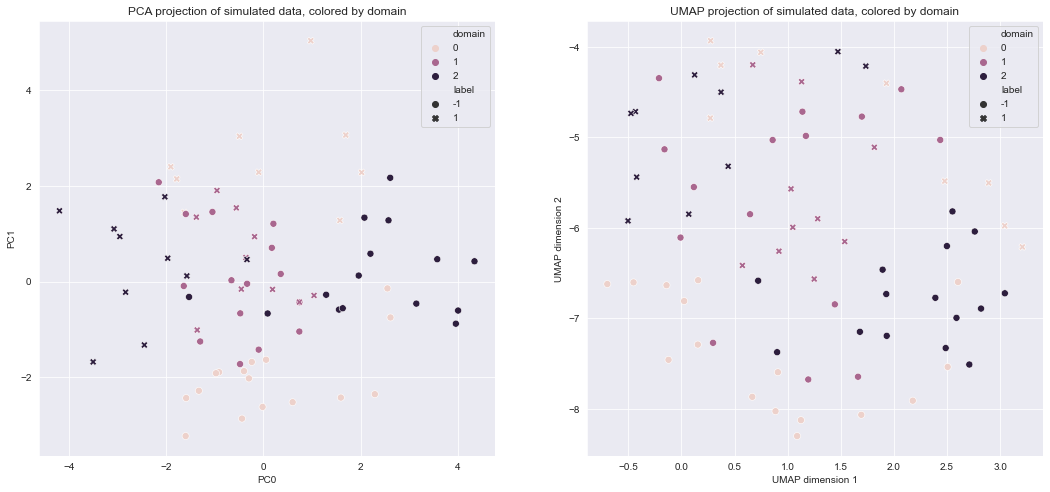

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [7]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
 
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.871429
1,random_forest,0,train_auroc,1.000000
2,mlp,0,train_auroc,0.931973
3,ridge,1,train_auroc,0.961538
4,random_forest,1,train_auroc,1.000000


(-0.1, 1.1)

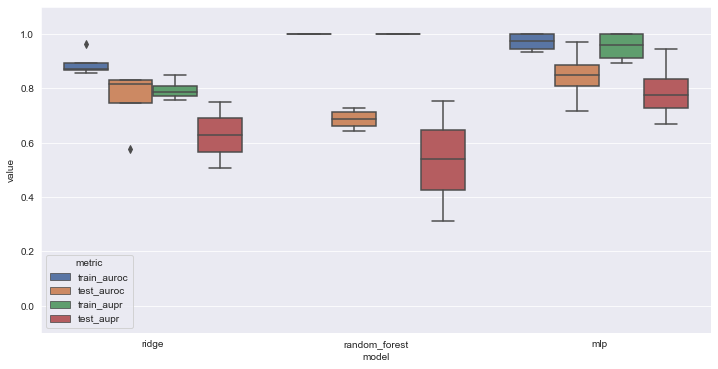

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)

In [9]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [10]:
xs_fixed = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_fixed[:5, :]) 

[[ 7.16372732e-01  1.93104653e-03  6.57310362e-01  1.46807004e+00
   1.86566522e+00  1.00306026e+00  1.23128803e+00 -1.22911626e+00
   9.19344677e-02 -1.33562232e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.01258509e-01 -2.26640312e+00 -4.62214808e-01  3.67276344e-01
   2.11868324e-01 -1.54182694e-01 -7.67333098e-01  2.24625876e+00
   5.48931279e-01  1.57522151e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.09641684e+00 -1.65428383e+00 -7.40010512e-01 -1.90531563e+00
   3.36522418e+00 -4.76405558e-01  5.07329369e-01  8.56114888e-01
   2.90908425e-01  1.02662310e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.24360953e+00 -1.44671719e+00 -3.79840099e-01 -1.44138196e+00
  -4.00928608e-01  1.70658726e+00  5.97431928e-01  1.08040949e+00
   7.20530831e-01  1.96231637e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.64138627e+00  1.12200153e+00  2.20793849e+00  2.56039971e+00
  -2.36147198e+00 -1.38248720e+00  5.76214340e-01 -2.84405246e+00


In [11]:
# split dataset into train/test
# this time with a covariate for domain membership (this should help performance)
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.847619
1,random_forest,0,train_auroc,1.000000
2,mlp,0,train_auroc,0.915646
3,ridge,1,train_auroc,0.889894
4,random_forest,1,train_auroc,1.000000


(-0.1, 1.1)

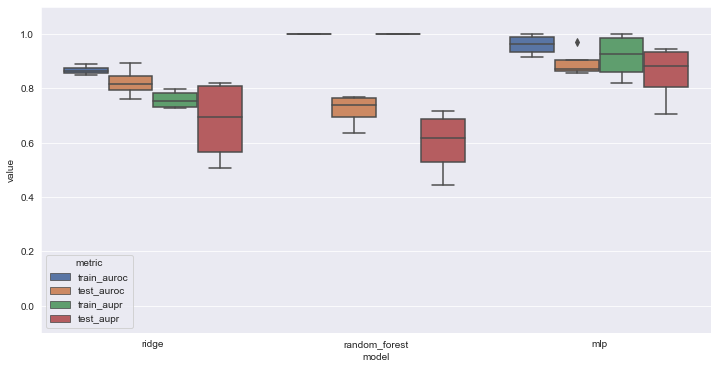

In [12]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)